# 1D noiseless illustrative example


In [1]:
# import standard libraries
# from mfbml.problems.illutrative_problems import mf_Forrester
from mfbml.methods.mf_rbf_kriging import MFRBFKriging
from mfbml.methods.rbf_regressor import RBFKernelRegression
from mfbml.metrics.accuracy_metrics import normalized_mae, normalized_rmse
from sklearn.metrics import r2_score

# import local packages
from mfpml.models.scale_kriging import ScaledKriging
from mfpml.models.hierarchical_kriging import HierarchicalKriging
from mfpml.problems.multifidelity_functions import Forrester_1b
from mfpml.models.co_kriging import CoKriging


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings

warnings.filterwarnings("ignore")

In [2]:
# fix the random seed for reproducibility
seed_number = 123
np.random.seed(seed_number)

## Get function and design of experiment


In [3]:
# define function
func = Forrester_1b()
# define sampler
# sampler = MFSobolSequence(design_space=func._input_domain,
#                           num_fidelity=2)
# sample_x = sampler.get_samples(num_samples = [])
# update sample_x['hf']
sample_xh = np.array([0.0, 0.4, 0.6, 1.0]).reshape((-1, 1))
sample_xl = np.linspace(0, 1, 11, endpoint=True).reshape((-1, 1))
sample_x = [sample_xh, sample_xl]
# get response

# sample_yh = func.hf(sample_x[0])
# sample_yl = func.lf(sample_x[1])
# sample_y = [sample_yh, sample_yl]
sample_y = func(sample_x)
# generate test samples
test_x = np.linspace(0, 1, 1000).reshape(-1, 1)
test_hy = func.hf(test_x)
test_ly = func.lf(test_x)

### MF-RBF-Krging


In [4]:
start_time = time.time()
mfrbfkriging_model = MFRBFKriging(
    design_space=func._input_domain,
    optimizer_restart=20,
    seed=seed_number
)
mfrbfkriging_model.lf_model = RBFKernelRegression(
    design_space=func._input_domain,
    params_optimize=False
)
mfrbfkriging_model.train(samples=sample_x,
                         responses=sample_y)
pred_y, pred_std = mfrbfkriging_model.predict(X=test_x,
                                              return_std=True)

# get prediction of low fidelity
pred_ly = mfrbfkriging_model.predict_lf(X=test_x)
end_time = time.time()
print("time: ", end_time - start_time)

# calculate accuracy metrics
nrmse_mf_rbf_kriging = normalized_rmse(test_hy, pred_y)
nmae_mf_rbf_kriging = normalized_mae(test_hy, pred_y)
r2_mf_rbf_kriging = r2_score(test_hy, pred_y)
cpu_time_mf_rbf_kriging = end_time - start_time
print("nrmse: ", nrmse_mf_rbf_kriging)
print("nmae: ", nmae_mf_rbf_kriging)
print("r2: ", r2_mf_rbf_kriging)
print("cpu_time: ", cpu_time_mf_rbf_kriging)

time:  0.07121801376342773
nrmse:  0.007260479255726432
nmae:  0.017530855041700887
r2:  0.9999822268894117
cpu_time:  0.07121801376342773


## HK method


In [5]:
# train model
start_time = time.time()
hk_model = HierarchicalKriging(
    design_space=func._input_domain,
    optimizer_restart=20,
    noise_prior=0.0)
hk_model.train(samples=sample_x,
               responses=sample_y)
# get prediction of low fidelity
hk_pred_ly = hk_model.predict_lf(X=test_x)
# get prediction of high fidelity
hk_pred_hy, hk_pred_std = hk_model.predict(X=test_x,
                                           return_std=True)
end_time = time.time()
# calculate accuracy metrics
nrmse_hk = normalized_rmse(test_hy, hk_pred_hy)
nmae_hk = normalized_mae(test_hy, hk_pred_hy)
r2_hk = r2_score(test_hy, hk_pred_hy)
cpu_time_hk = end_time - start_time

# print accuracy metrics
print("normalized rmse: ", nrmse_hk)
print("normalized mae: ", nmae_hk)
print("r2: ", r2_hk)
print("cpu_time: ", cpu_time_hk)

normalized rmse:  0.02275936817417398
normalized mae:  0.09467896769582565
r2:  0.9998253561615252
cpu_time:  0.6808395385742188


In [6]:
# co-kriging
start_time = time.time()
ck_model = CoKriging(design_space=func._input_domain,
                     optimizer_restart=20,
                     noise_prior=0)
ck_model.train(samples=sample_x,
               responses=sample_y)
# get prediction of low fidelity
ck_pred_ly = ck_model.predict_lf(X=test_x)
# get prediction of high fidelity
ck_pred_hy, ck_pred_std = ck_model.predict(X=test_x,
                                           return_std=True)
end_time = time.time()

# calculate accuracy metrics
nrmse = normalized_rmse(test_hy, ck_pred_hy)
nmae = normalized_mae(test_hy, ck_pred_hy)
r2 = r2_score(test_hy, ck_pred_hy)
cpu_time = end_time - start_time

# print accuracy metrics
print("normalized rmse: ", nrmse)
print("normalized mae: ", nmae)
print("r2: ", r2)
print("cpu_time: ", cpu_time)

normalized rmse:  0.022750919707761053
normalized mae:  0.09462569833360016
r2:  0.9998254857959454
cpu_time:  0.8975710868835449


In [7]:
# scaled kriging
start_time = time.time()
sk_model = ScaledKriging(design_space=func._input_domain,
                         optimizer_restart=20,
                         noise_prior=0)
sk_model.train(samples=sample_x, responses=sample_y)
# get prediction of low fidelity
sk_pred_ly = sk_model.predict_lf(X=test_x)
# get prediction of high fidelity
sk_pred_hy, sk_pred_std = sk_model.predict(X=test_x, return_std=True)
end_time = time.time()

# calculate accuracy metrics
nrmse_sk = normalized_rmse(test_hy, sk_pred_hy)
nmae_sk = normalized_mae(test_hy, sk_pred_hy)
r2_sk = r2_score(test_hy, sk_pred_hy)
cpu_time_sk = end_time - start_time

# print accuracy metrics
print("normalized mse: ", nrmse_sk)
print("normalized mae: ", nmae_sk)
print("r2: ", r2_sk)
print("cpu_time: ", cpu_time_sk)

normalized mse:  0.9723472869881604
normalized mae:  2.214434141503538
r2:  0.6812312944191015
cpu_time:  0.5039100646972656


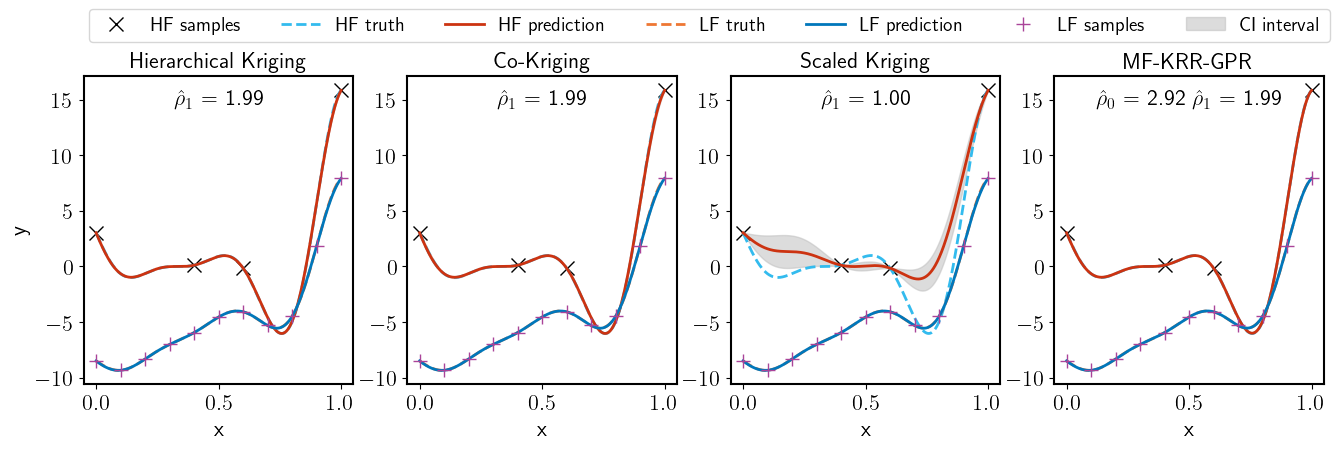

In [10]:
# plot results in 2x2 grid
font_size = 16
plt.rcParams["text.usetex"] = True
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[3].plot(
    sample_x[0],
    sample_y[0],
    "kx",
    linewidth=2,
    markersize=10,
    label="HF samples",
)
ax[3].plot(test_x, test_hy, "--", color="#33BBEE",
           linewidth=2, label="HF truth")
ax[3].plot(test_x, pred_y, "-", color="#CC3311",
           linewidth=2, label="HF prediction")
ax[3].plot(test_x, test_ly, "--", color="#EE7733",
           linewidth=2, label="LF truth")
ax[3].plot(test_x, pred_ly, "-", color="#0077BB",
           linewidth=2, label="LF prediction")
ax[3].plot(
    sample_x[1],
    sample_y[1],
    "+",
    color="#AA4499",
    linewidth=2,
    markersize=10,
    label="LF samples",
)
ax[3].fill_between(
    test_x.flatten(),
    (pred_y - 2 * pred_std).flatten(),
    (pred_y + 2 * pred_std).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
ax[3].set_title("MF-KRR-GPR", fontsize=font_size)
ax[3].set_ylabel(" ", fontsize=font_size)
ax[3].set_xlabel("x", fontsize=font_size)
ax[3].legend()
# for hierarchical kriging
ax[0].plot(
    sample_x[0],
    sample_y[0],
    "kx",
    linewidth=2,
    markersize=10,
    label="HF samples",
)
ax[0].plot(test_x, test_hy, "--", color="#33BBEE",
           linewidth=2, label="HF truth")
ax[0].plot(test_x, hk_pred_hy, "-", color="#CC3311",
           linewidth=2, label="HF prediction")
ax[0].plot(test_x, test_ly, "--", color="#EE7733",
           linewidth=2, label="LF truth")
ax[0].plot(test_x, hk_pred_ly, "-", color="#0077BB",
           linewidth=2, label="LF prediction")
ax[0].plot(
    sample_x[1],
    sample_y[1],
    "+",
    color="#AA4499",
    linewidth=2,
    markersize=10,
    label="LF samples",
)
ax[0].fill_between(
    test_x.flatten(),
    (hk_pred_hy - 2 * hk_pred_std).flatten(),
    (hk_pred_hy + 2 * hk_pred_std).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
ax[0].set_title("Hierarchical Kriging", fontsize=font_size)
ax[0].set_ylabel("y", fontsize=font_size)
ax[0].set_xlabel("x", fontsize=font_size)

# for co-kriging
ax[1].plot(
    sample_x[0],
    sample_y[0],
    "kx",
    linewidth=2,
    markersize=10,
    label="HF samples",
)
ax[1].plot(test_x, test_hy, "--", color="#33BBEE",
           linewidth=2, label="HF truth")
ax[1].plot(test_x, ck_pred_hy, "-", color="#CC3311",
           linewidth=2, label="HF prediction")
ax[1].plot(test_x, test_ly, "--", color="#EE7733",
           linewidth=2, label="LF truth")
ax[1].plot(test_x, ck_pred_ly, "-", color="#0077BB",
           linewidth=2, label="LF prediction")
ax[1].plot(
    sample_x[1],
    sample_y[1],
    "+",
    color="#AA4499",
    linewidth=2,
    markersize=10,
    label="LF samples",
)
ax[1].fill_between(
    test_x.flatten(),
    (ck_pred_hy - 2 * ck_pred_std).flatten(),
    (ck_pred_hy + 2 * ck_pred_std).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
ax[1].set_title("Co-Kriging", fontsize=font_size)
ax[1].set_ylabel(" ", fontsize=font_size)
ax[1].set_xlabel("x", fontsize=font_size)

# for scaled kriging
ax[2].plot(
    sample_x[0],
    sample_y[0],
    "kx",
    linewidth=2,
    markersize=10,
    label="HF samples",
)
ax[2].plot(test_x, test_hy, "--", color="#33BBEE",
           linewidth=2, label="HF truth")
ax[2].plot(test_x, sk_pred_hy, "-", color="#CC3311",
           linewidth=2, label="HF prediction")
ax[2].plot(test_x, test_ly, "--", color="#EE7733",
           linewidth=2, label="LF truth")
ax[2].plot(test_x, sk_pred_ly, "-", color="#0077BB",
           linewidth=2, label="LF prediction")
ax[2].plot(
    sample_x[1],
    sample_y[1],
    "+",
    color="#AA4499",
    linewidth=2,
    markersize=10,
    label="LF samples",
)
ax[2].fill_between(
    test_x.flatten(),
    (sk_pred_hy - 2 * sk_pred_std).flatten(),
    (sk_pred_hy + 2 * sk_pred_std).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
# write text on the plot of beta0= 0.5  and beta0= 0.5 on the middle top of the plot
ax[0].text(
    0.5,
    15.0,
    r"$\hat \rho_1$ = {:.2f}".format(
        hk_model.beta[0, 0],
    ),
    fontsize=font_size,
    ha="center",
    va="center",
    backgroundcolor="white",
)
ax[1].text(
    0.5,
    15.0,
    r"$\hat \rho_1$ = {:.2f}".format(
        ck_model.rho,
    ),
    fontsize=font_size,
    ha="center",
    va="center",
    backgroundcolor="white",
)
ax[2].text(
    0.5,
    15.0,
    r"$\hat \rho_1$ = {:.2f}".format(
        1.0,
    ),
    fontsize=font_size,
    ha="center",
    va="center",
    backgroundcolor="white",
)
# two numbers on the middle top of the plot for mf-rbf-kriging on two lines
ax[3].text(
    0.5,
    15.0,
    r"$\hat \rho_0$ = {:.2f}  $\hat \rho_1$ = {:.2f}".format(
        mfrbfkriging_model.beta[0, 0], mfrbfkriging_model.beta[1, 0]
    ),
    fontsize=font_size,
    ha="center",
    va="center",
    backgroundcolor="white",
)

ax[2].set_title("Scaled Kriging", fontsize=font_size)
ax[2].set_ylabel(" ", fontsize=font_size)
ax[2].set_xlabel("x", fontsize=font_size)


plt.legend(loc="upper center", bbox_to_anchor=(-1.28, 1.25),
           ncol=7, fontsize=14)
# set the font size of axis
for i in range(4):
    ax[i].tick_params(axis="both", which="major", labelsize=font_size)
    # set the line width of the axis
    for axis in ["top", "bottom", "left", "right"]:
        ax[i].spines[axis].set_linewidth(1.5)
plt.savefig("mf_rbf_gpr_noiseless_1d.pdf", bbox_inches="tight", dpi=300)
plt.savefig("mf_rbf_gpr_noiseless_1d.png", bbox_inches="tight", dpi=300)
plt.savefig("mf_rbf_gpr_noiseless_1d.svg", bbox_inches="tight", dpi=300)
plt.show()

In [9]:
# save the results into a pandas dataframe
df = pd.DataFrame(columns=["nrmse", "nmae", "r2", "lf_time", "hf_time"])
df.loc["hierarchical_kriging"] = [nrmse_hk, nmae_hk, r2_hk,
                                  hk_model.lf_training_time, hk_model.hf_training_time]
df.loc["co_kriging"] = [nrmse, nmae, r2,
                        ck_model.lf_training_time, ck_model.hf_training_time]
df.loc["scaled_kriging"] = [nrmse_sk, nmae_sk, r2_sk,
                            sk_model.lf_training_time, sk_model.hf_training_time]
df.loc["mf_rbf_kriging"] = [
    nrmse_mf_rbf_kriging,
    nmae_mf_rbf_kriging,
    r2_mf_rbf_kriging,
    mfrbfkriging_model.lf_training_time,
    mfrbfkriging_model.hf_training_time,
]
# save the results into a csv file
df.to_csv("result_of_illustrative_example.csv")

# print the results
print(df)

                         nrmse      nmae        r2   lf_time   hf_time
hierarchical_kriging  0.022759  0.094679  0.999825  0.601462  0.053531
co_kriging            0.022751  0.094626  0.999825  0.414870  0.470791
scaled_kriging        0.972347  2.214434  0.681231  0.395196  0.094196
mf_rbf_kriging        0.007260  0.017531  0.999982  0.000675  0.051518
